In [2]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

from sklearn.model_selection import train_test_split

In [3]:
sys.path.append(os.path.abspath('..'))
from src.generator import BraTSGenerator
from src.architectures.unet_3d import build_unet_3d
from src.training.losses import categorical_dice_loss, tumor_dice_coef

In [4]:
# Configuration
DATA_DIR = '../data/02_processed/train'
VAL_DATA_DIR = '../data/02_processed/val'
BATCH_SIZE = 2
EPOCHS = 200
LR = 1e-4
IMG_SIZE = (128, 128, 128)

EXP_NUMBER = 1

In [5]:
# Create model directory
model_dir = f"../models/model_{EXP_NUMBER}"
os.makedirs(model_dir, exist_ok=True)

In [6]:
# Split dataset
patient_ids = os.listdir(DATA_DIR)
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# --- Summary ---
print(f"Total patients: {len(patient_ids)}")
print("-" * 30)
print(f"TRAIN (70%):        {len(train_ids)} patients")
print(f"VALIDATION (15%):    {len(val_ids)} patients")
print(f"TEST (15%):          {len(test_ids)} patients")

Total patients: 369
------------------------------
TRAIN (70%):        258 patients
VALIDATION (15%):    55 patients
TEST (15%):          56 patients


In [7]:
# Create data generators
train_gen = BraTSGenerator(train_ids, DATA_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen = BraTSGenerator(val_ids, DATA_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

In [8]:
# Build and compile model
model = build_unet_3d(input_shape=(*IMG_SIZE, 4), start_filters=32)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=categorical_dice_loss, metrics=[tumor_dice_coef, 'accuracy'])
model.summary()

I0000 00:00:1770588588.744320   87063 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9498 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "U-Net_3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │     27,680 │ activation[0][0]  │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │    110,656 │ activation_2[0][… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d_1[… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_4[0][0]  

 Total params: 22,589,796 (86.17 MB)

 Trainable params: 22,583,908 (86.15 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [9]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f"{model_dir}/best_model.keras",
        verbose=1,
        save_best_only=True,
        monitor='val_tumor_dice_coef',
        mode='max'
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
		monitor='val_loss',
		factor=0.5,
		patience=5,
		verbose=1
	),

	tf.keras.callbacks.EarlyStopping(
        monitor='val_tumor_dice_coef',
        patience=15,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),

    tf.keras.callbacks.CSVLogger(
        f'{model_dir}/training_log.csv',
        separator=',',
        append=True
    )
]

In [10]:
# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
	verbose=1,
)

Epoch 1/200


I0000 00:00:1770588663.315086   87252 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.3112 - loss: 0.8783 - tumor_dice_coef: 0.1217
Epoch 1: val_tumor_dice_coef improved from None to 0.12578, saving model to ../models/model_1/best_model.keras

Epoch 1: finished saving model to ../models/model_1/best_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 171s 772ms/step - accuracy: 0.3960 - loss: 0.8204 - tumor_dice_coef: 0.1796 - val_accuracy: 0.4730 - val_loss: 0.8742 - val_tumor_dice_coef: 0.1258 - learning_rate: 1.0000e-04
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.4454 - loss: 0.7165 - tumor_dice_coef: 0.2835
Epoch 2: val_tumor_dice_coef improved from 0.12578 to 0.21957, saving model to ../models/model_1/best_model.keras

Epoch 2: finished saving model to ../models/model_1/best_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 98s 756ms/step - accuracy: 0.4440 - loss: 0.7052 - tumor_dice_coef: 0.2948 - val_accuracy: 0.4515 - val_loss: 0.7804 - val_tumor_dice_coef: 0.2196 - learning_rate: 1.0000e-04
Epoch 3/

In [11]:
model.save(f"{model_dir}/final_model.keras")

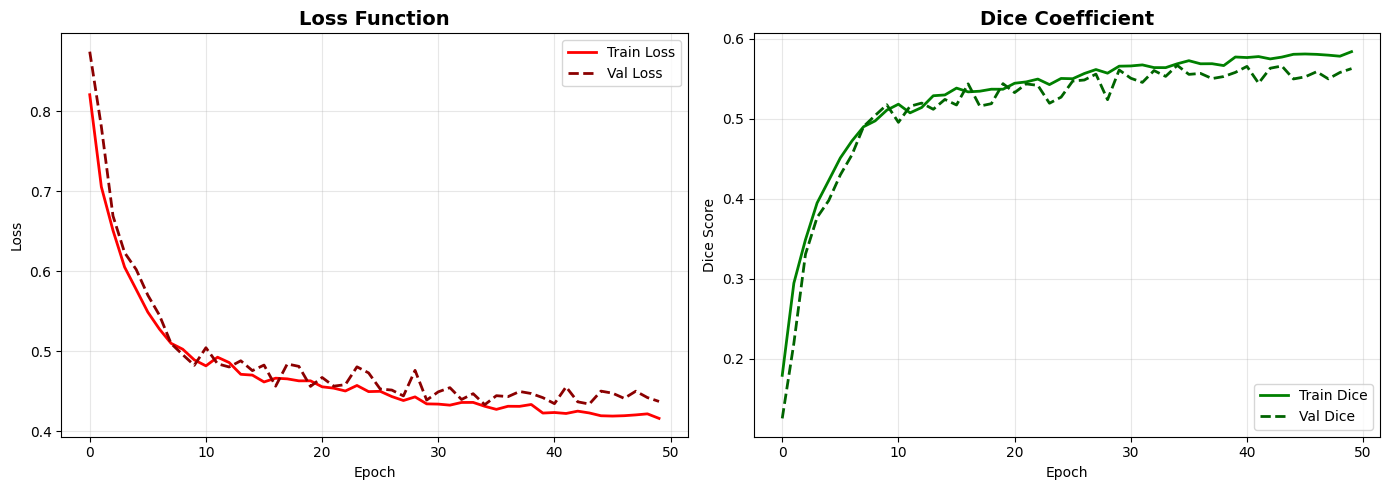

In [13]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='red')
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--', color='darkred')
axes[0].set_title('Loss Function', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['tumor_dice_coef'], label='Train Dice', linewidth=2, color='green')
axes[1].plot(history.history['val_tumor_dice_coef'], label='Val Dice', linewidth=2, linestyle='--', color='darkgreen')
axes[1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

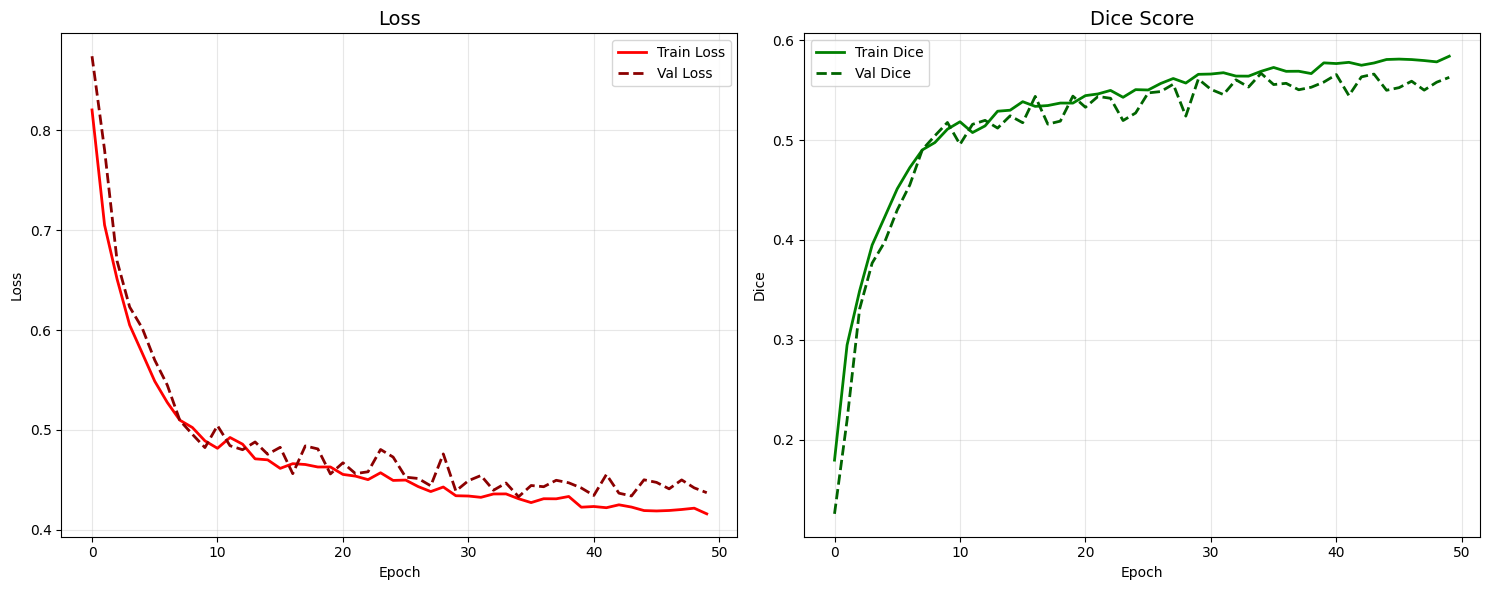

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = f'{model_dir}/training_log.csv'
history_df = pd.read_csv(log_path)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Loss
axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', linewidth=2, color='red')
if 'val_loss' in history_df.columns:
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2, linestyle='--', color='darkred')
axes[0].set_title('Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Dice
axes[1].plot(history_df['epoch'], history_df['tumor_dice_coef'], label='Train Dice', linewidth=2, color='green')
axes[1].plot(history_df['epoch'], history_df['val_tumor_dice_coef'], label='Val Dice', linewidth=2, linestyle='--', color='darkgreen')
axes[1].set_title('Dice Score', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Load model for test
import numpy as np
import nibabel as nib
from src.preprocessing import _normalize

import matplotlib.pyplot as plt

MODEL_PATH = f'{model_dir}/best_model.keras'
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'categorical_dice_loss': categorical_dice_loss, 'tumor_dice_coef': tumor_dice_coef}
)

In [19]:
def calculate_dice_metric(y_true, y_pred, class_id):
    y_true_f = (y_true == class_id).flatten()
    y_pred_f = (y_pred == class_id).flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    
    if union == 0:
        return 1.0
    
    return (2. * intersection) / union

In [20]:
results = []

for patient_id in test_ids:
    path = os.path.join(DATA_DIR, patient_id)
    
    try:
        vol = nib.load(os.path.join(path, 'volume.nii')).get_fdata()
        mask = nib.load(os.path.join(path, 'mask.nii')).get_fdata()
    except FileNotFoundError:
        continue

    X = np.expand_dims(vol, axis=0)
    if np.max(X) > 0:
        X = X / np.max(X)
    
    pred_raw = model.predict(X, verbose=0)
    pred_mask = np.argmax(pred_raw[0], axis=-1)
    
    if mask.ndim == 4:
        mask = np.argmax(mask, axis=-1)
    
    dice_1 = calculate_dice_metric(mask, pred_mask, 1) # Necrotic/Non-enhancing tumor core
    dice_2 = calculate_dice_metric(mask, pred_mask, 2) # Peritumoral Edema
    dice_3 = calculate_dice_metric(mask, pred_mask, 3) # Enhancing tumor
    mean_dice = (dice_1 + dice_2 + dice_3) / 3.0

    results.append({
        'Patient_ID': patient_id,
        'Dice_Class_1': dice_1,
        'Dice_Class_2': dice_2,
        'Dice_Class_3': dice_3,
        'Mean_Dice': mean_dice
    })

df_results = pd.DataFrame(results)

In [21]:
print(df_results)

              Patient_ID  Dice_Class_1  Dice_Class_2  Dice_Class_3  Mean_Dice
0   BraTS20_Training_138      0.032224           0.0           0.0   0.010741
1   BraTS20_Training_203      0.003750           0.0           0.0   0.001250
2   BraTS20_Training_163      0.023928           0.0           0.0   0.007976
3   BraTS20_Training_265      0.040556           0.0           1.0   0.346852
4   BraTS20_Training_252      0.027212           0.0           0.0   0.009071
5   BraTS20_Training_107      0.000567           0.0           0.0   0.000189
6   BraTS20_Training_321      0.026913           0.0           1.0   0.342304
7   BraTS20_Training_232      0.006948           0.0           0.0   0.002316
8   BraTS20_Training_270      0.007567           0.0           0.0   0.002522
9   BraTS20_Training_327      0.120643           0.0           0.0   0.040214
10  BraTS20_Training_256      0.045608           0.0           0.0   0.015203
11  BraTS20_Training_241      0.021705           0.0           0